# Step by step reconstruction of the model

In [52]:
import numpy as np
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def load_data(img_dir, ending):
    return np.array([cv2.imread(os.path.join(img_dir, img)) for img in os.listdir(img_dir) if img.endswith(ending)])


In [16]:
X_ORG = load_data("3Shapes2_large/", "im1.png")
Y_ORG = load_data("3Shapes2_large/","im2.png")

In [17]:
X_ORG.shape

(8015, 128, 128, 3)

In [72]:
X = X_ORG[:10]
Y = Y_ORG[:10]

In [73]:
def create_graph(img1, img2, batch_size):
    img1_64 = tf.nn.max_pool(img1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    img2_64 = tf.nn.max_pool(img2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    #Motion encoder

    #First convolution: 5x5x96
    weights = tf.Variable(tf.random_normal([5,5,3,96]))
    bias = tf.Variable(tf.zeros([96,]))
    logits = tf.nn.conv2d(img1_64, filter=weights, strides=[1,1,1,1], padding='SAME')
    logits = tf.add(logits, bias)
    logits = tf.nn.relu(logits)
    
    #Second convolution: 5x5x96
    weights = tf.Variable(tf.random_normal([5,5,96,96]))
    bias = tf.Variable(tf.zeros([96,]))
    logits = tf.nn.conv2d(logits, filter=weights, strides=[1,1,1,1], padding='SAME')
    logits = tf.add(logits, bias)
    logits = tf.nn.max_pool(logits, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    logits = tf.nn.relu(logits)
    
    #Third convolution: 5x5x128
    weights = tf.Variable(tf.random_normal([5,5,96,128])) # 128
    bias = tf.Variable(tf.zeros([128,]))
    logits = tf.nn.conv2d(logits, filter=weights, strides=[1,1,1,1], padding='SAME')
    logits = tf.add(logits, bias)
    logits = tf.nn.max_pool(logits, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    logits = tf.nn.relu(logits)
    
    #Forth convolution: 5x5x128
    weights = tf.Variable(tf.random_normal([5,5,128,128]))
    bias = tf.Variable(tf.zeros([128,]))
    logits = tf.nn.conv2d(logits, filter=weights, strides=[1,1,1,1], padding='VALID')
    logits = tf.add(logits, bias)
    logits = tf.nn.max_pool(logits, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    logits = tf.nn.relu(logits)

    #Fifth convolution: 5x5x256
    weights = tf.Variable(tf.random_normal([5,5,128,3])) #256
    bias = tf.Variable(tf.zeros([3,]))
    logits = tf.nn.conv2d(logits, filter=weights, strides=[1,1,1,1], padding='VALID')
    logits = tf.add(logits, bias)
    logits = tf.nn.max_pool(logits, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    logits = tf.nn.relu(logits)

    #Sixth convolution: 5x5x256
    '''weights = tf.Variable(tf.random_normal([5,5,256,3])) # TODO change 3 for 256
    bias = tf.Variable(tf.zeros([3,]))
    logits = tf.nn.conv2d(logits, filter=weights, strides=[1,1,1,1], padding='SAME')
    logits = tf.add(logits, bias)
    logits = tf.nn.relu(logits)'''
    
    logits = tf.image.resize_images(logits, [64,128])
    
    #flatten
    logits_flatten = tf.reshape(logits, shape=[logits.shape.as_list()[0],-1])
    
    # mean and std
    mean, std_log = tf.split(logits_flatten, 2, axis=1)
    epsilon = tf.random_normal(mean.shape.as_list(),0,1, dtype=tf.float32)
    kernel = mean + tf.multiply(tf.exp(std_log),epsilon)
    
    kernel = tf.reshape(kernel, shape=[batch_size,64,64,3])
    
    return img1_64, img2_64, kernel


In [74]:
def train(prediction, y):
    l2_loss = tf.reduce_mean(tf.square(prediction - y))
    optimizer = tf.train.AdamOptimizer(0.01)
    train = optimizer.minimize(l2_loss)
    
    return l2_loss, train

In [75]:
# run the model
def run(X, Y, n_epochs = 10, batch_size = 30):
    img1 = tf.placeholder(shape=(batch_size,128,128,3), dtype=tf.float32, name="s1s")
    img2 = tf.placeholder(shape=(batch_size,128,128,3), dtype=tf.float32)
    
    img1_64, img2_64, output = create_graph(img1, img2, batch_size)
    loss, training = train(output, img2_64)
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(n_epochs):
            
            print('Epoch %i/%i' % (epoch+1, n_epochs))
            cumulative_loss = 0.0
            
            for batch_num in range(int(X.shape[0]/batch_size)-1):
                # get x and y
                from_index = batch_size*batch_num
                to_index = batch_size*batch_num + batch_size
                x = X[from_index:to_index]
                y = Y[from_index:to_index]
                
                # run train and loss
                _, batch_loss = sess.run([training,loss], feed_dict={img1:x, img2:y})
                print("\t\tbatch_loss:", batch_loss)
                cumulative_loss += batch_loss
            
            print("\tEpoch's loss:", cumulative_loss)
        
        final = output.eval(feed_dict={img1:X_ORG[11:13],img2:Y_ORG[11:13]})[0]
        
        fig, axs = plt.subplots(2)
        axs[0].imshow(X_ORG[11])
        axs[1].imshow(final)

                

# TODO
1. Solve the nan problem
2. Integrate different sizes

Epoch 1/10
		batch_loss: inf
		batch_loss: 41455.6
		batch_loss: 46386.2
		batch_loss: 40832.4
	Epoch's loss: inf
Epoch 2/10
		batch_loss: 43458.9
		batch_loss: 41454.8
		batch_loss: 46385.3
		batch_loss: 40830.4
	Epoch's loss: 172129.292969
Epoch 3/10
		batch_loss: 43460.7
		batch_loss: 41451.0
		batch_loss: 46380.5
		batch_loss: 40831.2
	Epoch's loss: 172123.390625
Epoch 4/10
		batch_loss: 43449.6
		batch_loss: 41456.0
		batch_loss: 46388.4
		batch_loss: 40827.7
	Epoch's loss: 172121.714844
Epoch 5/10
		batch_loss: 43457.3
		batch_loss: 41447.6
		batch_loss: 46389.8
		batch_loss: 40827.6
	Epoch's loss: 172122.273438
Epoch 6/10
		batch_loss: 43457.4
		batch_loss: 41451.0
		batch_loss: 46382.7
		batch_loss: 40827.3
	Epoch's loss: 172118.429688
Epoch 7/10
		batch_loss: 43458.7
		batch_loss: 41451.1
		batch_loss: 46383.9
		batch_loss: 40833.1
	Epoch's loss: 172126.796875
Epoch 8/10
		batch_loss: 43455.5
		batch_loss: 41453.6
		batch_loss: 46383.6
		batch_loss: 40829.6
	Epoch's loss: 1721

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


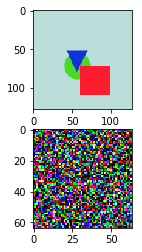

In [77]:
run(X, Y, 10, 2)